# Model Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import shap
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from matplotlib.patches import Patch

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
governance = ["ceo_is_female","unequal_voting","ceo_tenure","board_size","classified_board_system","poison_pill","buyback_yield",
              "dividend_payout_ratio","cf_to_total_compensation_to_executives","cf_to_total_compensation_to_board_members"]

operation = ["cf_to_capex_industry_peers_percentile","net_debt_to_ebitda_industry_peers_percentile",
             "current_ratio_industry_peers_percentile","ebitda_margin_industry_peers_percentile",
             "sales_to_total_assets_industry_peers_percentile","employee_growth_rate_industry_peers_percentile",
             "fcf_yield_industry_peers_percentile","sales_growth_rate_industry_peers_percentile",
             "cash_conversion_cycle_industry_peers_percentile","interest_coverage_ratio_industry_peers_percentile"]

ownership = ["free_float_percentage","institution_ownership_percentage","insider_shares_percentage"]

technical= ['rsi_14d','rsi_30d','volatility_30d','volatility_90d','volatility_180d',"volume_30d_average_to_outstanding"]

returns = ['total_return_5y', 'total_return_4y', 'total_return_3y','total_return_2y', 'total_return_1y', 'total_return_6m','total_return_3m']

valuation = ["roe_industry_peers_percentile","operating_roic_industry_peers_percentile","pe_ratio_industry_peers_percentile",
             "eps_industry_peers_percentile","ev_to_sales_industry_peers_percentile","tobin_q_ratio_industry_peers_percentile",
             "pb_ratio_industry_peers_percentile","asset_to_equity_industry_peers_percentile","ev_ebitda_industry_peers_percentile", "ev_to_asset_industry_peers_percentile"]

binary = ["ceo_is_female","unequal_voting", "classified_board_system","poison_pill"]

features = governance + operation + ownership + technical + returns + valuation


descriptive_names = ["CEO is female","existence of dual-class voting rights", "CEO's tenure", "board size", "existence of classified board system", "existence of poison pill", "buyback yield",
                     "dividend payout ratio", "free cash flow to total comepensation to executives", "free cash flow to total compensation to board members",
                     "free cash flow to capex", "net debt to EBITDA", "current ratio", "EBITDA margin",
                     "sales to total assets", "employee growth rate", "free cash flow yield", "sales growth rate",
                     "cash conversion cycle", "interest coverage ratio", "free float percentage", "percentage of institutional ownership", "percentage of insider ownership",
                     "14-day RSI", "30-day RSI", "30-day volatility", "90-day volatility", "180-day volatility", "30-day average trading volume to outstanding shares",
                     "5-year total return", "4-year total return", "3-year total return", "2-year total return", "1-year total return", "6-month total return", "3-month total return",
                     "return on equity(ROE)", "return on invested capital(ROIC)", "price-earnings ratio(PER)", "earnings per share(EPS)", "enterprise value to sales", "Tobin's Q ratio",
                     "price-to-book ratio (PBR)", "assets to equity", "EV/EBITDA", "enterprise value to asset"]

feature_name_mapping = dict(zip(features, descriptive_names))

In [3]:
df_results = pd.read_csv('../models/AUROC_table.csv')

In [4]:
df_results_sorted = df_results.sort_values(by=['auroc_test'], ascending = False)
df_above_70 = df_results_sorted[df_results_sorted['auroc_test']>0.70]
df_above_70

,Unnamed: 0,model,auroc_train,auroc_test,top_30_hit_num,top_30_hit_rate
59,59,KNN_BorderlineSmote_LogisticRegression,0.774893,0.782143,5,0.166667
24,24,Median_BorderlineSmote_LogisticRegression,0.766905,0.769841,4,0.133333
129,129,GAIN_BorderlineSmote_LogisticRegression,0.776167,0.766766,5,0.166667
94,94,MiceForest_BorderlineSmote_LogisticRegression,0.769891,0.752480,5,0.166667
95,95,MiceForest_BorderlineSmote_RandomForestClassifier,1.000000,0.727976,4,0.133333
130,130,GAIN_BorderlineSmote_RandomForestClassifier,1.000000,0.708879,5,0.166667
132,132,GAIN_BorderlineSmote_LGBMClassifier,0.996678,0.707341,3,0.100000
61,61,KNN_BorderlineSmote_XGBClassifier,0.999983,0.705853,4,0.133333
60,60,KNN_BorderlineSmote_RandomForestClassifier,1.000000,0.705804,3,0.100000
42,42,KNN_Original_CatBoostClassifier,0.996947,0.701334,7,0.233333


In [5]:
df_results_sorted.head(10)

,Unnamed: 0,model,auroc_train,auroc_test,top_30_hit_num,top_30_hit_rate
59,59,KNN_BorderlineSmote_LogisticRegression,0.774893,0.782143,5,0.166667
24,24,Median_BorderlineSmote_LogisticRegression,0.766905,0.769841,4,0.133333
129,129,GAIN_BorderlineSmote_LogisticRegression,0.776167,0.766766,5,0.166667
94,94,MiceForest_BorderlineSmote_LogisticRegression,0.769891,0.752480,5,0.166667
95,95,MiceForest_BorderlineSmote_RandomForestClassifier,1.000000,0.727976,4,0.133333
130,130,GAIN_BorderlineSmote_RandomForestClassifier,1.000000,0.708879,5,0.166667
132,132,GAIN_BorderlineSmote_LGBMClassifier,0.996678,0.707341,3,0.100000
61,61,KNN_BorderlineSmote_XGBClassifier,0.999983,0.705853,4,0.133333
60,60,KNN_BorderlineSmote_RandomForestClassifier,1.000000,0.705804,3,0.100000
42,42,KNN_Original_CatBoostClassifier,0.996947,0.701334,7,0.233333


## 1. Run scaled logistic regression and analyze coefficients

Among 7 models whose test AUROC exceeds 0.7, 6 are logistic regression. We therefore compute the coefficient values of scaled logistic regression and check relative importances of different features. 

In [6]:
def get_scaled_LR_coefficients(df_list, df_names, features, binary):
    # Initialize a DataFrame to store the coefficients for each feature
    coefficients = pd.DataFrame(index=features, columns=df_names)
    
    # Separate binary and non-binary features
    non_binary_features = [f for f in features if f not in binary]
    
    # Iterate over each DataFrame and corresponding name
    for df, name in zip(df_list, df_names):
        # Select the relevant features and the target indicator for training data
        data = df[features + ['training_data', 'targeted']]
        X_train = data[data['training_data'] == 1].drop(columns=['training_data', 'targeted'])
        y_train = data[data['training_data'] == 1]['targeted']
        X_test = data[data['training_data'] == 0].drop(columns=['training_data', 'targeted'])

        # Scale only non-binary features
        scaler = StandardScaler()
        if non_binary_features:  # Check if there are non-binary features to scale
            X_train_scaled = X_train.copy()
            X_train_scaled[non_binary_features] = scaler.fit_transform(X_train[non_binary_features])
        else:
            X_train_scaled = X_train  # If no non-binary features, proceed without scaling

        # Fit a logistic regression model
        model = LogisticRegression()
        model.fit(X_train_scaled, y_train)
        
        # Store the coefficients for this DataFrame in the appropriate column
        coefficients[name] = model.coef_[0]
    
    # Reset index to make the features column a regular column
    coefficients.reset_index(inplace=True)
    coefficients.rename(columns={'index': 'feature'}, inplace=True)
    
    coefficients['feature'] = coefficients['feature'].map(feature_name_mapping)
    
    # Calculate mean value of coefficients and sort by the absolute value of mean_value
    coefficients['mean_value'] = coefficients[df_names].mean(axis=1)
    coefficients.sort_values(by='mean_value', key=lambda x: x.abs(), ascending=False, inplace=True)

    return coefficients


In [7]:
df_knn_borderlinesmote = pd.read_csv('../Database/companies/imputation/kNN/kNN_BORDERLINESMOTE.csv')
df_median_borderlinesmote = pd.read_csv('../Database/companies/imputation/median/median_BORDERLINESMOTE.csv')
df_gain_borderlinesmote = pd.read_csv('../Database/companies/imputation/GAIN/GAIN_BORDERLINESMOTE.csv')
df_miceforest_borderlinesmote = pd.read_csv('../Database/companies/imputation/MiceForest/MiceForest_BORDERLINESMOTE.csv')

df_list = [
    df_knn_borderlinesmote,
    df_median_borderlinesmote,
    df_gain_borderlinesmote,
    df_miceforest_borderlinesmote
]

df_names = [
    "KNN_BorderlineSmote_LR_0.782",
    "Median_BorderlineSmote_LR_0.770",
    "GAIN_BorderlineSmote_LR_0.768"
    "MiceForest_BorderlineSmote_LR_0.752"
]

Columns (51,52,53,55,56,57,129) have mixed types. Specify dtype option on import or set low_memory=False.
Columns (51,52,53,55,56,57,122,123,124,125,126,127,128,129) have mixed types. Specify dtype option on import or set low_memory=False.
Columns (51,52,53,55,56,57,122,123,124,125,126,127,128,129) have mixed types. Specify dtype option on import or set low_memory=False.
Columns (51,52,53,55,56,57,122,123,124,125,126,127,128,129) have mixed types. Specify dtype option on import or set low_memory=False.


In [8]:
coefficient_table = get_scaled_LR_coefficients(df_list, df_names, features, binary)

In [9]:
coefficient_table

,feature,KNN_BorderlineSmote_LR_0.782,Median_BorderlineSmote_LR_0.770,GAIN_BorderlineSmote_LR_0.768MiceForest_BorderlineSmote_LR_0.752,mean_value
20,free float percentage,0.537818,0.614406,0.594531,0.582252
24,30-day RSI,-0.456911,-0.385206,-0.590642,-0.477586
30,4-year total return,-0.558035,-0.394096,-0.354335,-0.435489
23,14-day RSI,0.375290,0.312921,0.407900,0.365370
40,enterprise value to sales,-0.342564,-0.383324,-0.298928,-0.341605
5,existence of poison pill,0.172912,0.345352,0.361151,0.293138
1,existence of dual-class voting rights,-0.284817,-0.243067,-0.293658,-0.273847
41,Tobin's Q ratio,-0.346195,-0.133986,-0.317552,-0.265911
9,free cash flow to total compensation to board ...,-0.439335,-0.067868,-0.102070,-0.203091
37,return on invested capital(ROIC),-0.216268,-0.280028,-0.112341,-0.202879


In [10]:
def plot_sorted_coefficients(coefficient_table, column_name, table_name):
    # Sort the coefficient table based on the absolute values of the specified column in descending order
    sorted_table = coefficient_table.sort_values(
        by=column_name,
        key=lambda x: abs(x),
        ascending=False
    )

    # Extract sorted features and their corresponding coefficient values
    features_sorted = sorted_table['feature']
    mean_values_sorted = sorted_table[column_name].abs()
    colors_sorted = ['lightcoral' if x > 0 else 'skyblue' for x in sorted_table[column_name]]

    # Create the bar plot with sorted values
    plt.figure(figsize=(10, 8))
    plt.barh(features_sorted, mean_values_sorted, color=colors_sorted)
    legend_elements = [Patch(facecolor='lightcoral', label='Positive'),Patch(facecolor='skyblue', label='Negative')]
    plt.legend(handles=legend_elements, loc='lower right', title="Coefficient Sign")
    plt.ylabel('Features')
    plt.xlabel('Absolute Coefficient Value')
    plt.title(table_name)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

### A. Mean values of top 3 scaled linear regression models

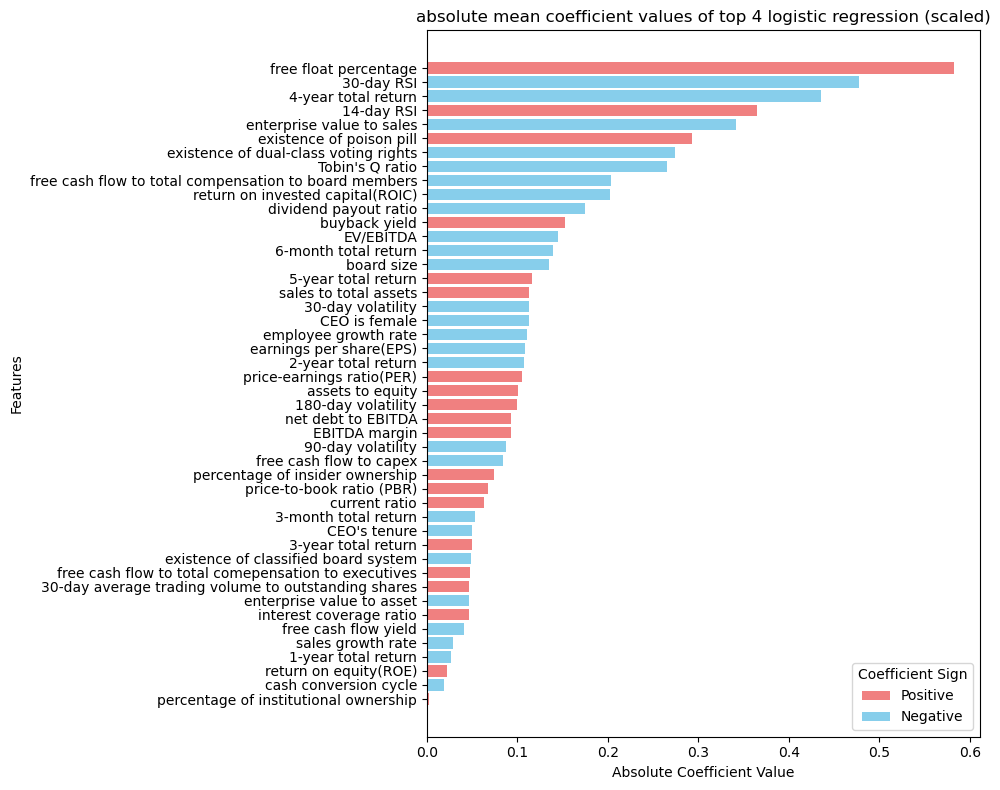

In [11]:
plot_sorted_coefficients(coefficient_table,'mean_value',"absolute mean coefficient values of top 4 logistic regression (scaled)")


### B. Median imputation + Borderline SMOTE oversampling (top 1)

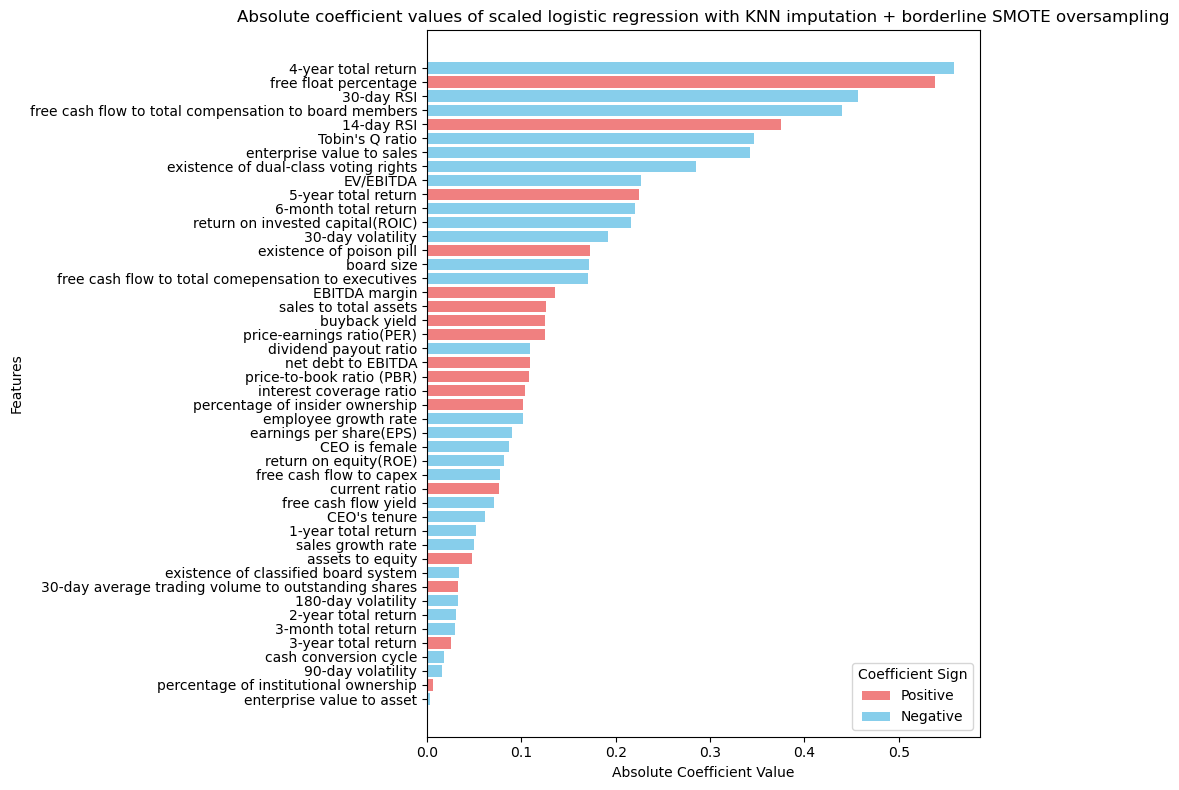

In [12]:
plot_sorted_coefficients(coefficient_table, 'KNN_BorderlineSmote_LR_0.782',"Absolute coefficient values of scaled logistic regression with KNN imputation + borderline SMOTE oversampling")

## 2. Compute SHAP values

In [13]:
knn_borderlinesmote_LR = joblib.load('../models/KNN/BorderlineSmote/KNN_BorderlineSmote_LogisticRegression.joblib')
median_borderlinesmote_LR = joblib.load('../models/Median/BorderlineSmote/Median_BorderlineSmote_LogisticRegression.joblib')
gain_borderlinesmote_LR = joblib.load('../models/GAIN/BorderlineSmote/GAIN_BorderlineSmote_LogisticRegression.joblib')
miceforest_borderlinesmote_LR = joblib.load('../models/MiceForest/BorderlineSmote/MiceForest_BorderlineSmote_LogisticRegression.joblib')

df_names = [
    "KNN_BorderlineSmote_LR_0.782",
    "Median_BorderlineSmote_LR_0.770",
    "GAIN_BorderlineSmote_LR_0.768",
    "MiceForest_BorderlineSmote_LR_0.752"
]

models_dict = {
    "KNN_BorderlineSmote_LR_0.782" : (knn_borderlinesmote_LR, df_knn_borderlinesmote),
    "Median_BorderlineSmote_LR_0.770" : (median_borderlinesmote_LR, df_median_borderlinesmote),
    "GAIN_BorderlineSmote_LR_0.768" : (gain_borderlinesmote_LR, df_gain_borderlinesmote),
    "MiceForest_BorderlineSmote_LR_0.752" : (miceforest_borderlinesmote_LR, df_miceforest_borderlinesmote)
}

In [14]:
# Prepare DataFrame to store SHAP values
shap_values_dict = {'feature': features}

# Iterate over each model and dataset in the dictionary
for model_name, (model, df) in models_dict.items():
    # Splitting the data
    X_train = df[features]
    y_train = df['targeted']
    X_test = df[features]  # Assuming you use the same df for simplicity here
    y_test = df['targeted']

    # Compute SHAP values
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)
    mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)  # Mean absolute SHAP values for each feature

    # Add to the dictionary
    shap_values_dict[model_name] = mean_abs_shap_values

# Convert dictionary to DataFrame
df_shap = pd.DataFrame(shap_values_dict)
df_shap['feature'] = df_shap['feature'].map(feature_name_mapping)
df_shap.columns = ['feature'] + list(models_dict.keys())  # Correct column names with model performance metrics

# Compute the mean absolute value
df_shap['mean_abs_value'] = df_shap[df_names].mean(axis=1)

df_shap


,feature,KNN_BorderlineSmote_LR_0.782,Median_BorderlineSmote_LR_0.770,GAIN_BorderlineSmote_LR_0.768,MiceForest_BorderlineSmote_LR_0.752,mean_abs_value
0,CEO is female,0.007339,0.009055,0.000123,0.010993,0.006877
1,existence of dual-class voting rights,0.033694,0.030305,0.000783,0.046391,0.027793
2,CEO's tenure,0.046482,0.053950,0.044859,0.032962,0.044563
3,board size,0.104999,0.132047,0.035268,0.099389,0.092926
4,existence of classified board system,0.010354,0.005746,0.002442,0.008065,0.006652
5,existence of poison pill,0.007759,0.010654,0.000116,0.013084,0.007903
6,buyback yield,0.006539,0.004525,0.050952,0.003484,0.016375
7,dividend payout ratio,0.046623,0.061648,0.116299,0.043882,0.067113
8,free cash flow to total comepensation to execu...,0.017963,0.002670,0.187665,0.003506,0.052951
9,free cash flow to total compensation to board ...,0.039596,0.003129,0.023443,0.007975,0.018536


In [15]:
def plot_shap_values(df, column, name):
    # Sort the DataFrame by the specified column in descending order
    df_sorted = df.sort_values(by=column, ascending=False)
    
    # Create a bar plot
    plt.figure(figsize=(10, 8))  # Set the figure size (optional, adjust as needed)
    plt.barh(df_sorted['feature'], df_sorted[column], color='skyblue')  # Horizontal bar plot
    plt.xlabel('Mean (|SHAP|) Value')  # Label for the x-axis
    plt.ylabel('Features')  # Label for the y-axis
    plt.title(name)  # Set the title of the figure
    plt.gca().invert_yaxis()  # Invert the y-axis to have the highest value at the top
    plt.tight_layout()  # Adjust layout to fit labels, titles, etc.

    # Show the plot
    plt.show()


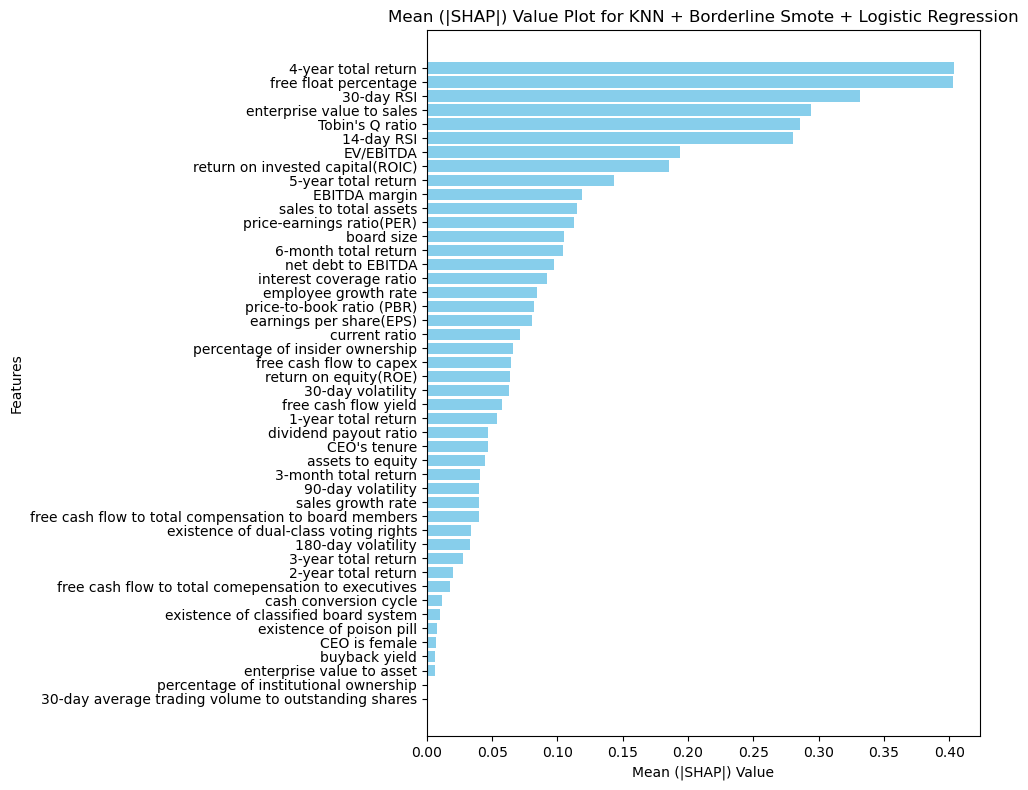

In [16]:
plot_shap_values(df_shap, 'KNN_BorderlineSmote_LR_0.782', 'Mean (|SHAP|) Value Plot for KNN + Borderline Smote + Logistic Regression')


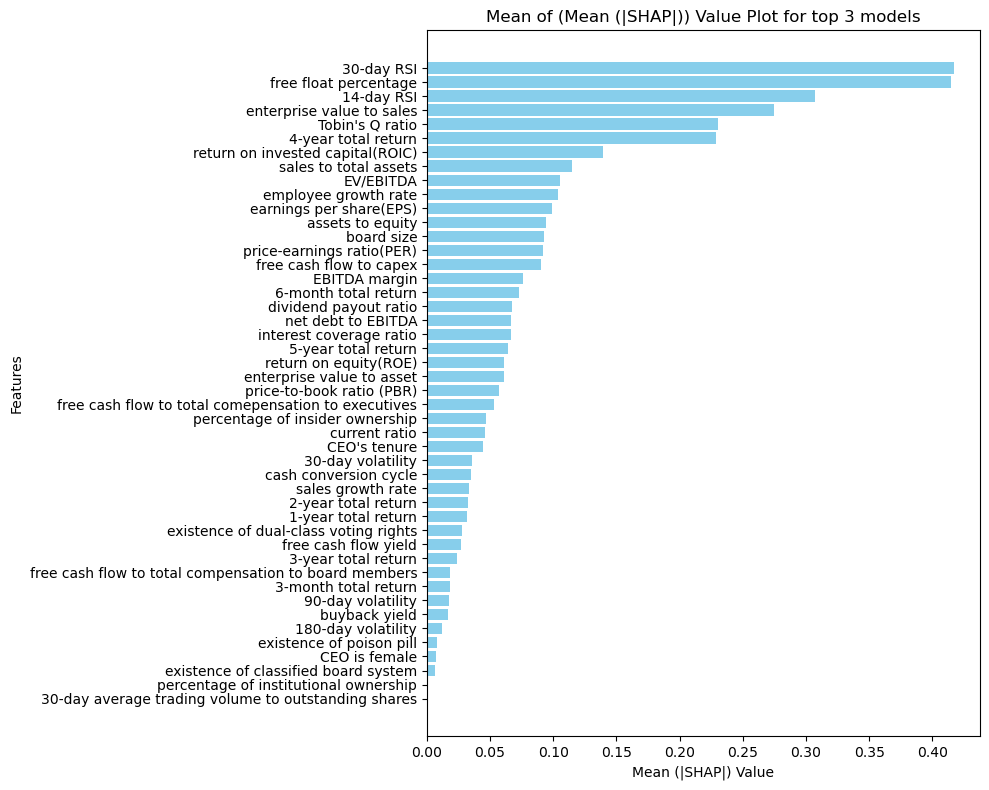

In [17]:
plot_shap_values(df_shap, 'mean_abs_value', 'Mean of (Mean (|SHAP|)) Value Plot for top 3 models')


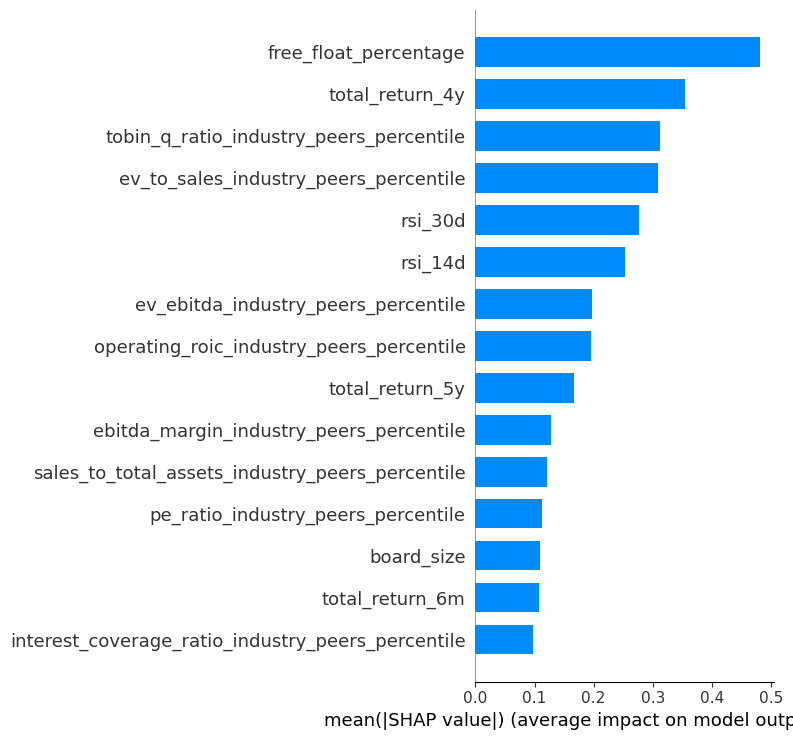

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


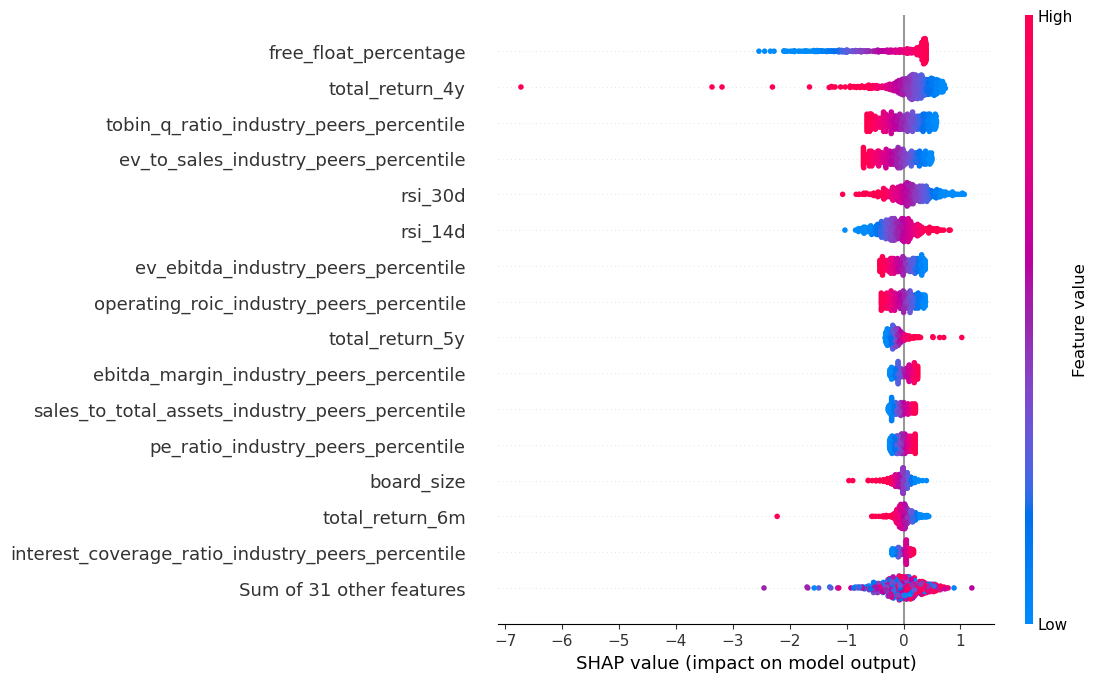

In [18]:
train_data = df_knn_borderlinesmote[df_knn_borderlinesmote['training_data'] == 1]
test_data = df_knn_borderlinesmote[df_knn_borderlinesmote['training_data'] == 0]

X_train = train_data[features]
y_train = train_data['targeted']
X_test = test_data[features]
y_test = test_data['targeted']

explainer = shap.Explainer(knn_borderlinesmote_LR, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)  # Note the change here; newer SHAP uses direct call on data

# Plot summary plot using SHAP values
shap.summary_plot(shap_values.values, X_test, plot_type="bar",max_display=15)
shap.plots.beeswarm(shap_values, max_display=16)

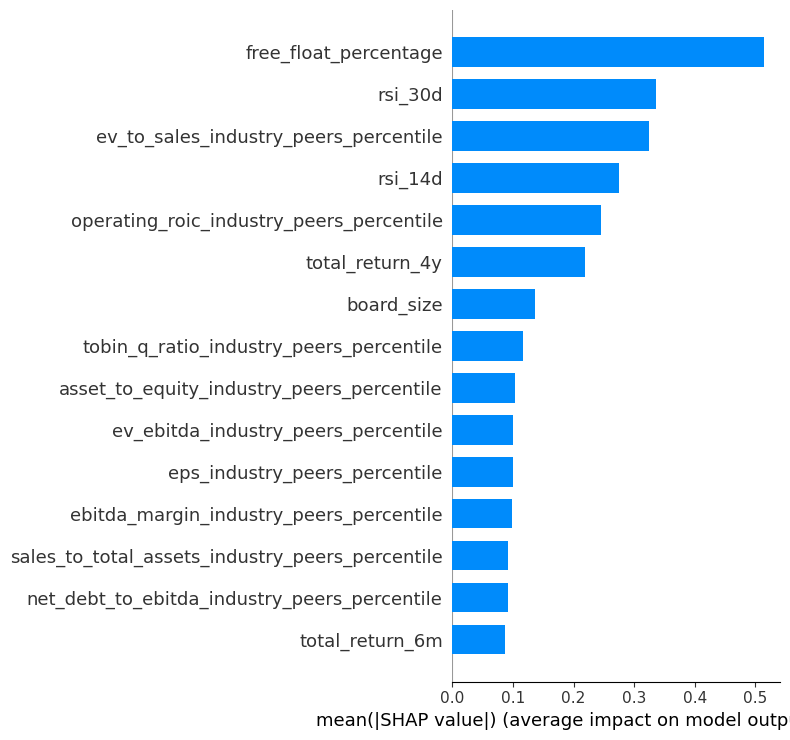

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


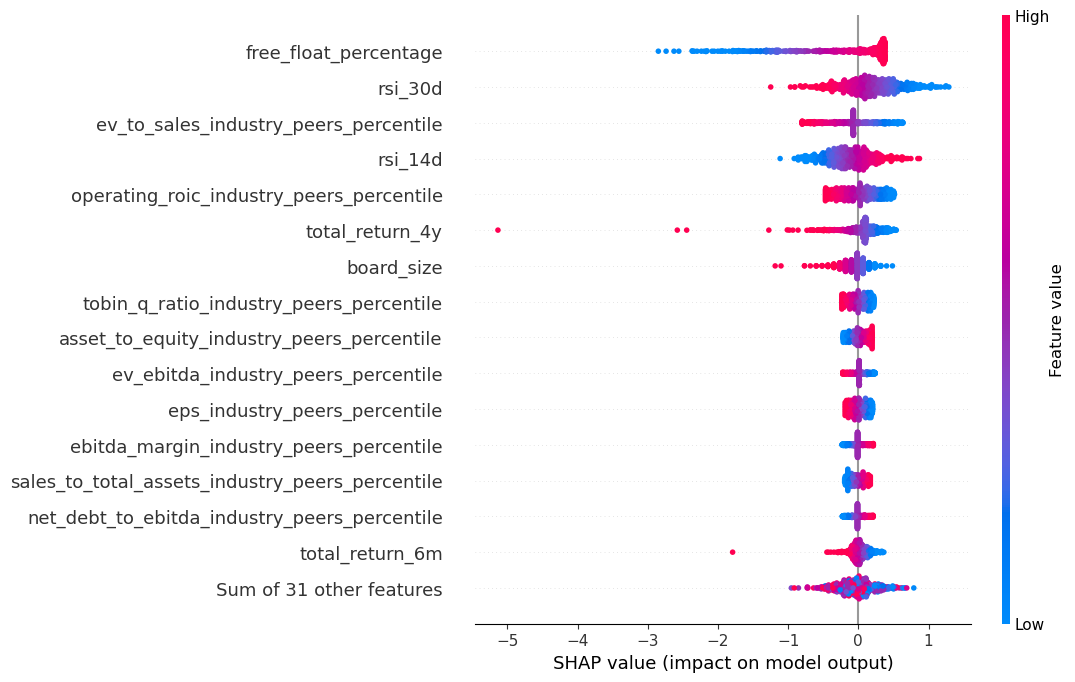

In [19]:
train_data = df_median_borderlinesmote[df_median_borderlinesmote['training_data'] == 1]
test_data = df_median_borderlinesmote[df_median_borderlinesmote['training_data'] == 0]

X_train = train_data[features]
y_train = train_data['targeted']
X_test = test_data[features]
y_test = test_data['targeted']

explainer = shap.Explainer(median_borderlinesmote_LR, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)  # Note the change here; newer SHAP uses direct call on data

# Plot summary plot using SHAP values
shap.summary_plot(shap_values.values, X_test, plot_type="bar",max_display=15)
shap.plots.beeswarm(shap_values, max_display=16)

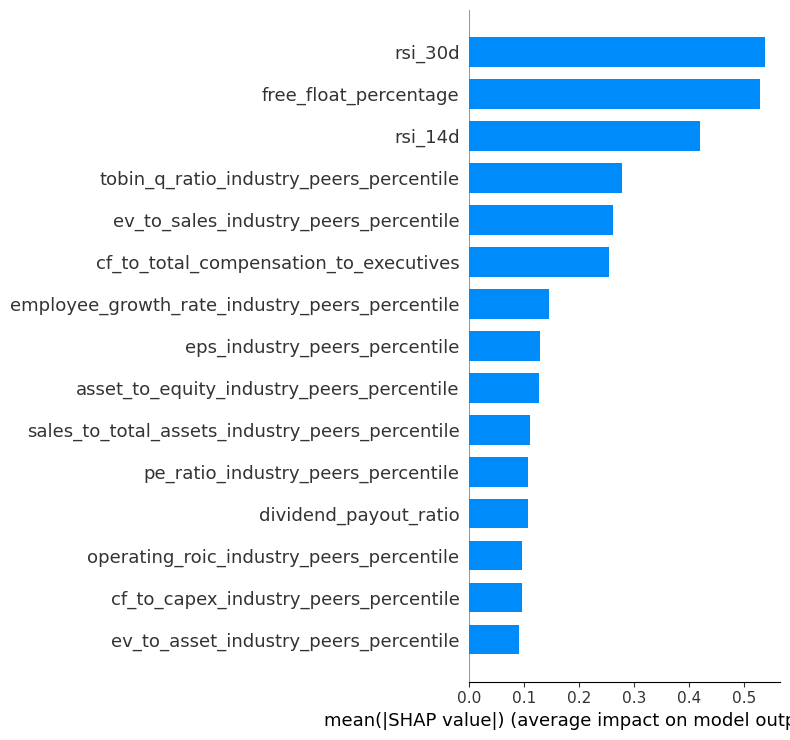

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


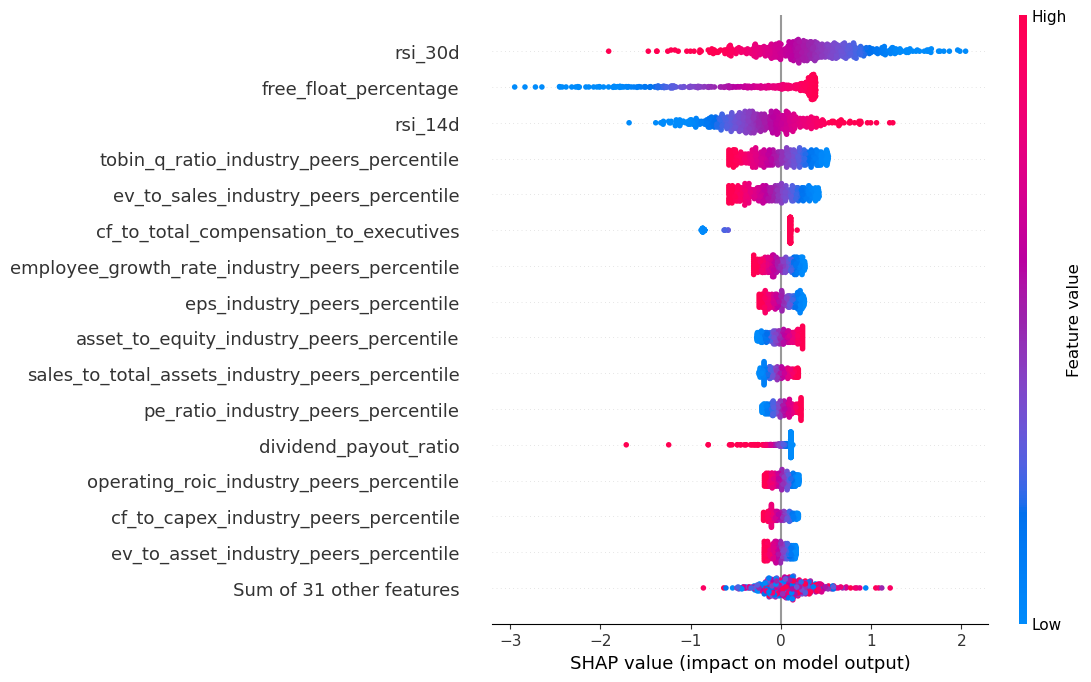

In [20]:
train_data = df_gain_borderlinesmote[df_gain_borderlinesmote['training_data'] == 1]
test_data = df_gain_borderlinesmote[df_gain_borderlinesmote['training_data'] == 0]

X_train = train_data[features]
y_train = train_data['targeted']
X_test = test_data[features]
y_test = test_data['targeted']

explainer = shap.Explainer(gain_borderlinesmote_LR, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)  # Note the change here; newer SHAP uses direct call on data

# Plot summary plot using SHAP values
shap.summary_plot(shap_values.values, X_test, plot_type="bar",max_display=15)
shap.plots.beeswarm(shap_values, max_display=16)

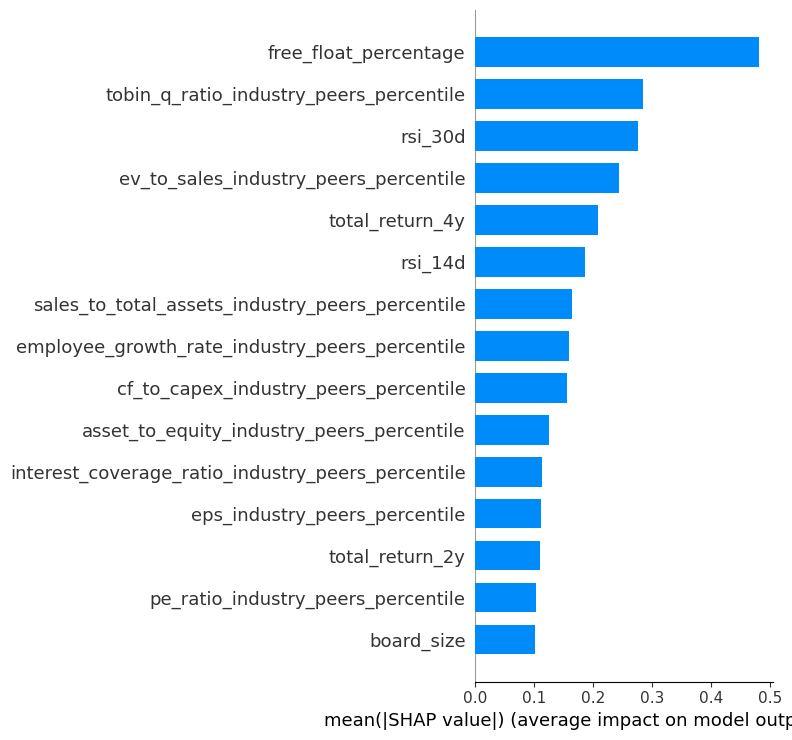

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


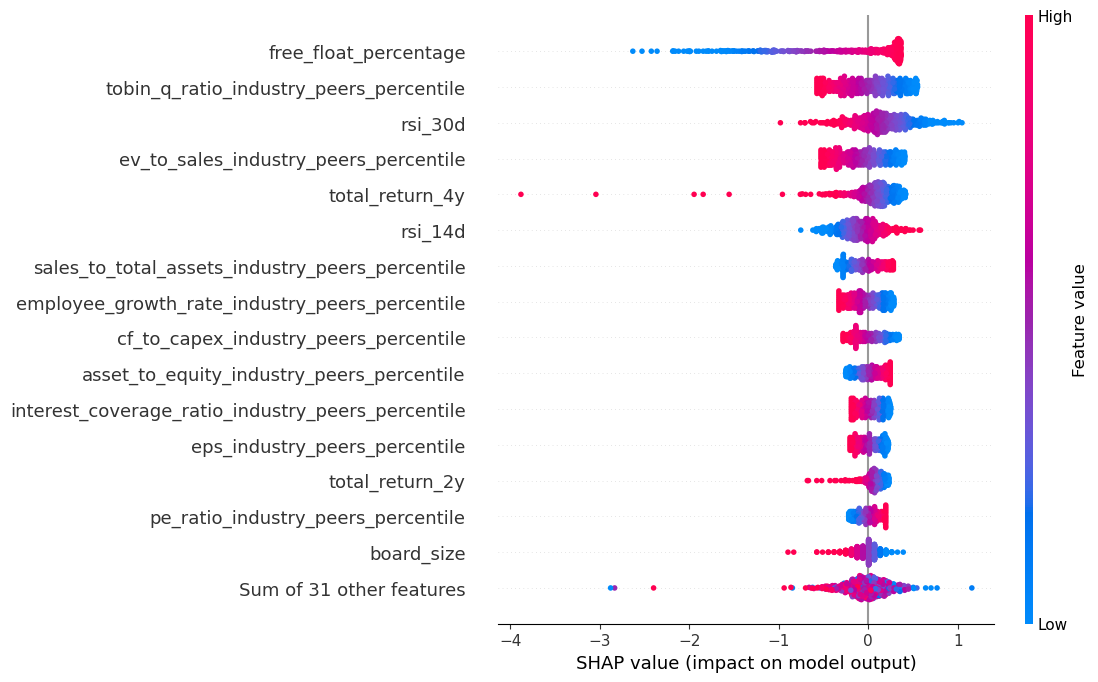

In [21]:
train_data = df_miceforest_borderlinesmote[df_miceforest_borderlinesmote['training_data'] == 1]
test_data = df_miceforest_borderlinesmote[df_miceforest_borderlinesmote['training_data'] == 0]

X_train = train_data[features]
y_train = train_data['targeted']
X_test = test_data[features]
y_test = test_data['targeted']

explainer = shap.Explainer(miceforest_borderlinesmote_LR, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)  # Note the change here; newer SHAP uses direct call on data

# Plot summary plot using SHAP values
shap.summary_plot(shap_values.values, X_test, plot_type="bar",max_display=15)
shap.plots.beeswarm(shap_values, max_display=16)